# Background

In notebook 3, we look at the type 1 error rate and power in GDP t-tests. Here we extend GDP to the bivariate case and look again at the impact of GDP on the type 1 error rate and power.

## Key differences from notebook 3

1. We use bivariate data.
2. We use only a one sample t-test (no mean and std separately)
3. In the simulations, we vary the effect size i.e. the means of each variables and change the correlation between the two variables, i.e. the covariance structure of the data. This mimicks 'mass-univariate' analyses where multiple correlated outcomes are measured on the same individuals.

# user_pipeline

This function performs one-sample t-tests against 0 for each vector in bivariate data, and returns the results.

A user here is asking to compute this workflow on unseen data.

In [4]:
def user_pipeline(data):
    """
    Performs one-sample t-tests against 0 for each vector in bivariate data.
    
    Args:
        data: numpy array of shape (2, n) or (n, 2) containing two vectors
    
    Returns:
        output: array containing [t1, p1, t2, p2] where:
                t1, p1 = t-statistic and p-value for first vector
                t2, p2 = t-statistic and p-value for second vector
    """
    from scipy.stats import ttest_1samp
    import numpy as np
    
    # Ensure data is in the right format (2, n)
    if data.shape[0] != 2:
        if data.shape[1] == 2:
            data = data.T  # transpose if it's (n, 2)
        else:
            raise ValueError("Data must be either (2, n) or (n, 2) shape")
    
    # Extract the two vectors
    vector1 = data[0, :]
    vector2 = data[1, :]
    
    # Initialize output array
    t1_, p1_, t2_, p2_ = 0, 1, 2, 3
    output = np.full((4,), np.nan)
    
    # Perform one-sample t-tests against 0 for each vector
    output[t1_], output[p1_] = ttest_1samp(vector1, popmean=0)
    output[t2_], output[p2_] = ttest_1samp(vector2, popmean=0)
    
    return output

# global differential privacy

This function applies GDP to the user_pipeline output by adding Gaussian noise based on the sensitivity of the statistic being computed, itself derived from a leave-one-out analysis.

## accounting for covariance

Unlike in the univariate case, the sensitivity of the t-statistic in the bivariate case depends on the covariance structure of the data. Here, we select the noise from a bivariate Gaussian distribution with a covariance matrix that reflects the covariance structure of the data, i.e. use the loo standard deviation for the scale of each Gaussian (as before) but the off-diagonal elements of the covariance matrix from the data. This ensures that the added noise is appropriately scaled for each variable and accounts for their correlation.

## fast_loo_statistics with jit

The `@jit(nopython=True)` decorator from numba provides Just-In-Time compilation for efficient computation of leave-one-out statistics for bivariate data.

**Performance gains**: Similar to the univariate case, expect ~5-10x improvement after initial compilation for vectorized operations on both variables simultaneously.

In [5]:
%pip install numba

from numba import jit
import numpy as np

@jit(nopython=True)
def fast_loo_statistics(data):
    """
    Vectorized computation of leave-one-out t-statistics for bivariate data.
    JIT-compiled with numba for ~5-10x speedup.
    
    Args:
        data: array of shape (2, n) containing two vectors
    
    Returns:
        loo_t_stats1: array of leave-one-out t-statistics for first vector
        loo_t_stats2: array of leave-one-out t-statistics for second vector
    """
    n = data.shape[1]
    
    # Process each vector separately
    loo_t_stats1 = np.zeros(n)
    loo_t_stats2 = np.zeros(n)
    
    for i in range(2):  # For each vector
        vector = data[i, :]
        data_sum = np.sum(vector)
        data_sq_sum = np.sum(vector**2)
        
        # Leave-one-out means: (sum - x_i) / (n-1)
        loo_means = (data_sum - vector) / (n - 1)
        
        # Leave-one-out variances
        loo_vars = ((data_sq_sum - vector**2) - (n-1) * loo_means**2) / (n - 2)
        loo_stds = np.sqrt(loo_vars)
        
        # Leave-one-out t-statistics: mean / (std / sqrt(n-1))
        loo_t_stats = loo_means / (loo_stds / np.sqrt(n - 1))
        
        if i == 0:
            loo_t_stats1 = loo_t_stats
        else:
            loo_t_stats2 = loo_t_stats
    
    return loo_t_stats1, loo_t_stats2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Cholesky decomposition for multivariate normal sampling

Since numba's JIT compilation doesn't support `np.random.multivariate_normal`, we use an equivalent approach with Cholesky decomposition:

1. **Cholesky decomposition**: For a covariance matrix Σ, we compute L = cholesky(Σ) where L is lower triangular and Σ = L @ L.T
2. **Sampling equivalence**: If Z ~ N(0, I) (independent standard normals), then X = L @ Z ~ N(0, Σ)
3. **Implementation**: `chol_factor = np.linalg.cholesky(noise_cov)` gives us L, then `noise = chol_factor @ z` where z is standard normal

This produces identical results to `np.random.multivariate_normal([0,0], noise_cov)` but is compatible with numba JIT compilation.

In [18]:
@jit(nopython=True)
def generate_dp_noise_cholesky(chol_factor, sens_t1, sens_t2, max_attempts=10000):
    """
    JIT-compiled function to generate bivariate noise using Cholesky decomposition.
    This avoids the multivariate_normal function which isn't supported in numba.
    
    Args:
        chol_factor: 2x2 Cholesky factor of covariance matrix (lower triangular)
        sens_t1: sensitivity constraint for first t-statistic
        sens_t2: sensitivity constraint for second t-statistic
        max_attempts: maximum number of attempts to generate valid noise
    
    Returns:
        noise: 2-element array with generated noise
        success: boolean indicating if constraints were satisfied
    """
    for attempt in range(max_attempts):
        # Generate independent standard normal variables
        z = np.random.standard_normal(2)
        
        # Transform to correlated noise using Cholesky factor
        noise = chol_factor @ z
        
        # Check if noise respects sensitivity constraints
        if (abs(noise[0]) >= sens_t1 and abs(noise[1]) >= sens_t2):
            return noise, True
    
    # Return last generated noise if max_attempts reached
    return noise, False

In [21]:
def bivariate_dp(data, original_output):
    """
    Apply DP to bivariate t-statistics using covariance-aware noise.
    
    Args:
        data: input data array of shape (2, n)
        original_output: output from user_pipeline [t1, p1, t2, p2]
    
    Returns:
        noisy_outputs: dict with noisy versions of 't1', 't2'
        sensitivities: dict with sensitivity values for each statistic
    """
    import numpy as np
    from scipy.stats import t as t_dist
    epsilon = 1.0

    # Compute all leave-one-out statistics vectorized
    loo_t_stats1, loo_t_stats2 = fast_loo_statistics(data)
    
    # Compute sensitivities for both t-statistics
    sensitivities = {
        't1': np.max(np.abs(loo_t_stats1 - original_output[0])),
        't2': np.max(np.abs(loo_t_stats2 - original_output[2]))
    }
    
    # Compute noise covariance matrix
    # Start with data covariance matrix and scale it appropriately
    data_cov = np.cov(data)
    
    # Compute loo scales
    loo_scale1 = np.std(loo_t_stats1) / epsilon
    loo_scale2 = np.std(loo_t_stats2) / epsilon
    
    # Create scaling matrix to transform data covariance to noise covariance
    # Scale factor for each variable
    scale_factor1 = (2 * loo_scale1) / np.sqrt(data_cov[0, 0])
    scale_factor2 = (2 * loo_scale2) / np.sqrt(data_cov[1, 1])
    
    # Create diagonal scaling matrix
    scale_matrix = np.diag([scale_factor1, scale_factor2])
    
    # Transform covariance matrix: S * Cov * S where S is scaling matrix
    noise_cov = scale_matrix @ data_cov @ scale_matrix
    
    # Ensure positive definiteness by adding small regularization if needed
    eigenvals = np.linalg.eigvals(noise_cov)
    if np.min(eigenvals) <= 1e-10:
        noise_cov += np.eye(2) * 1e-8
    
    # Try correlated noise generation first
    try:
        chol_factor = np.linalg.cholesky(noise_cov)
        noise, success = generate_dp_noise_cholesky(chol_factor, sensitivities['t1'], sensitivities['t2'])
        
        if success:
            # Correlated noise generation succeeded
            noise1, noise2 = noise[0], noise[1]
        else:
            # Correlated noise failed, fall back to independent noise
            raise ValueError("Correlated noise generation failed")
            
    except (np.linalg.LinAlgError, ValueError):
        # Fallback: generate independent noise for each variable (like notebook 3)
        import warnings
        warnings.warn("Failed to generate correlated noise, using independent noise for each variable")
        
        # Generate independent noise for each t-statistic
        noise1 = np.random.normal(0, 2 * loo_scale1)
        noise2 = np.random.normal(0, 2 * loo_scale2)
        
        # Ensure noise satisfies sensitivity constraints
        while abs(noise1) < sensitivities['t1']:
            noise1 = np.random.normal(0, 2 * loo_scale1)
        while abs(noise2) < sensitivities['t2']:
            noise2 = np.random.normal(0, 2 * loo_scale2)
    
    # Apply noise to original t-statistics
    noisy_outputs = {
        't1': original_output[0] + noise1,
        't2': original_output[2] + noise2
    }
    
    return noisy_outputs, sensitivities

# Simulations

We test the error rates and power of the t-test under different conditions.
(1) varying sample sizes
(2) varying effect sizes
(3) varying correlation between the two variables

## Effect size and correlation design

We use a common simulation design where:
- Effect sizes vary independently for each variable (0, 0.2, 0.5, 0.8)
- Correlations vary between variables (0, 0.3, 0.6, 0.9)
- This creates scenarios from independent variables to highly correlated ones
- Effect size combinations include: both null (0,0), one active (0.5,0), both active same (0.5,0.5), both active different (0.2,0.8)

## Limitations: Positive definite covariance matrices

Our approach requires the noise covariance matrix to be positive definite for Cholesky decomposition. This limitation can be encountered in real-world mass-univariate analyses, particularly in neuroimaging:

**Brain imaging scenarios where non-positive definite matrices occur:**

1. **MRI/fMRI**: Adjacent voxels often have near-perfect correlations (r > 0.95) due to spatial smoothing, creating ill-conditioned covariance matrices
2. **MEG/EEG**: Sensors measuring the same neural source can produce nearly identical signals, leading to rank-deficient covariance structures
3. **High-dimensional data**: When the number of variables approaches or exceeds sample size (common in whole-brain analyses)
4. **Perfect multicollinearity**: When brain regions have identical activation patterns across subjects
5. **Temporal correlations**: In time-series analysis where consecutive time points are perfectly correlated

When such matrices are encountered, our implementation falls back to diagonal noise (independent variables), which may underestimate the true correlation structure but ensures computational stability.

In [23]:
from joblib import Parallel, delayed
import numpy as np
from scipy.stats import ttest_1samp, t as t_dist
import time
import warnings

def run_single_mc_iteration_bivariate(mc, effect_sizes, sample_sizes, correlations, alpha=0.05):
    """Run a single Monte Carlo iteration for bivariate data with optimized DP computation"""
    iteration_results = []
    failed_noise_count = 0  # Track failed correlated noise generation
    
    for effect_size in effect_sizes:
        # effect_size is a tuple (effect1, effect2)
        effect1, effect2 = effect_size
        
        for correlation in correlations:
            # Create covariance matrix with unit variances and specified correlation
            cov_matrix = np.array([[1.0, correlation], 
                                   [correlation, 1.0]])
            
            # Generate master dataset of maximum sample size with specified means and covariance
            means = np.array([effect1, effect2])
            master_data = np.random.multivariate_normal(means, cov_matrix, max(sample_sizes)).T
            
            for sample_size in sample_sizes:
                # Create subsample
                data = master_data[:, :sample_size]
                
                # (1) Get original t-test results
                original_output = user_pipeline(data)
                
                # (2) Get DP results and capture warnings
                with warnings.catch_warnings(record=True) as w:
                    warnings.simplefilter("always")
                    noisy_outputs, sensitivities = bivariate_dp(data, original_output)
                    
                    # Check if correlated noise generation failed (fallback to independent noise)
                    noise_failed = any("Failed to generate correlated noise" in str(warning.message) for warning in w)
                    if noise_failed:
                        failed_noise_count += 1
                
                # Compute p-values from noisy t-statistics
                dp_p1 = 2 * (1 - t_dist.cdf(np.abs(noisy_outputs['t1']), df=sample_size-1))
                dp_p2 = 2 * (1 - t_dist.cdf(np.abs(noisy_outputs['t2']), df=sample_size-1))
                
                # Store results
                iteration_results.append({
                    'mc_iteration': mc,
                    'effect1': effect1,
                    'effect2': effect2,
                    'correlation': correlation,
                    'sample_size': sample_size,
                    'original_t1': original_output[0],
                    'original_p1': original_output[1],
                    'original_t2': original_output[2],
                    'original_p2': original_output[3],
                    'original_significant1': original_output[1] < alpha,
                    'original_significant2': original_output[3] < alpha,
                    'dp_t1': noisy_outputs['t1'],
                    'dp_p1': dp_p1,
                    'dp_t2': noisy_outputs['t2'],
                    'dp_p2': dp_p2,
                    'dp_significant1': dp_p1 < alpha,
                    'dp_significant2': dp_p2 < alpha,
                    'sensitivity_t1': sensitivities['t1'],
                    'sensitivity_t2': sensitivities['t2'],
                    'correlated_noise_failed': noise_failed
                })
    
    return iteration_results, failed_noise_count

# Parallel Monte Carlo simulations for bivariate case
MC_bivariate = 2000

# Varying sample sizes
sample_sizes_bivariate = [20, 50, 100, 200]

# Varying effect size combinations (effect1, effect2)
effect_sizes_bivariate = [
    (0.0, 0.0),  # Both null
    (0.0, 0.5),  # One active
    (0.5, 0.0),  # Other active
    (0.2, 0.2),  # Both small
    (0.5, 0.5),  # Both medium
    (0.8, 0.8),  # Both large
    (0.2, 0.8),  # Different magnitudes
]

# Varying correlations
correlations_bivariate = [0.0, 0.3, 0.6, 0.9]

alpha_bivariate = 0.05

print("Starting bivariate Monte Carlo simulation...")
print(f"Running {MC_bivariate} iterations across:")
print(f"  - {len(sample_sizes_bivariate)} sample sizes: {sample_sizes_bivariate}")
print(f"  - {len(effect_sizes_bivariate)} effect size combinations")
print(f"  - {len(correlations_bivariate)} correlation levels: {correlations_bivariate}")
print(f"Total combinations per iteration: {len(sample_sizes_bivariate) * len(effect_sizes_bivariate) * len(correlations_bivariate)}")
print(f"Using 20 parallel jobs with JIT-optimized DP computation\n")

# Start timing
start_time = time.time()

# Run parallel simulation
parallel_results_bivariate = Parallel(n_jobs=20, verbose=10, batch_size=1)(
    delayed(run_single_mc_iteration_bivariate)(mc, effect_sizes_bivariate, sample_sizes_bivariate, 
                                               correlations_bivariate, alpha_bivariate) 
    for mc in range(MC_bivariate)
)

# Calculate final timing
end_time = time.time()
total_time = end_time - start_time

# Flatten results and count failed noise generations
results_bivariate = []
total_failed_noise = 0

for result_tuple in parallel_results_bivariate:
    iteration_results, failed_count = result_tuple
    results_bivariate.extend(iteration_results)
    total_failed_noise += failed_count

print(f"\n\nBivariate simulation complete!")
print(f"Total time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
print(f"Average time per iteration: {total_time/MC_bivariate:.2f} seconds")
print(f"Total results: {len(results_bivariate)}")
print(f"Expected results: {MC_bivariate * len(sample_sizes_bivariate) * len(effect_sizes_bivariate) * len(correlations_bivariate)}")
print(f"\nCorrelated noise generation failures: {total_failed_noise} out of {len(results_bivariate)} ({100*total_failed_noise/len(results_bivariate):.2f}%)")

Starting bivariate Monte Carlo simulation...
Running 2000 iterations across:
  - 4 sample sizes: [20, 50, 100, 200]
  - 7 effect size combinations
  - 4 correlation levels: [0.0, 0.3, 0.6, 0.9]
Total combinations per iteration: 112
Using 20 parallel jobs with JIT-optimized DP computation



[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    0.4s
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done  73 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done  73 tasks      | elapsed:    0.7s
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:    0.8s
[Parallel(n_jobs=20)]: Done 105 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:  



Bivariate simulation complete!
Total time: 14.3 seconds (0.2 minutes)
Average time per iteration: 0.01 seconds
Total results: 224000
Expected results: 224000

Correlated noise generation failures: 878 out of 224000 (0.39%)


[Parallel(n_jobs=20)]: Done 2000 out of 2000 | elapsed:   14.3s finished


# Results Analysis

We analyze the type 1 error rates and power for both original and DP t-tests across different scenarios:
1. **Type 1 error**: False positive rate when both effects are null (0,0)
2. **Power**: True positive rate when effects are present
3. **Correlation effects**: How correlation between variables affects DP performance
4. **Sample size effects**: Performance across different sample sizes

The analysis considers each variable independently as well as joint significance patterns.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Convert results to DataFrame for easier analysis
df = pd.DataFrame(results_bivariate)

print(f"Total simulations: {len(df)}")
print(f"Correlated noise failures: {total_failed_noise} ({100*total_failed_noise/len(df):.2f}%)")
print(f"\nUnique combinations:")
print(f"- Effect sizes: {len(df[['effect1', 'effect2']].drop_duplicates())}")
print(f"- Correlations: {df['correlation'].nunique()}")
print(f"- Sample sizes: {df['sample_size'].nunique()}")
print(f"- MC iterations: {df['mc_iteration'].nunique()}")

Total simulations: 224000
Correlated noise failures: 878 (0.39%)

Unique combinations:
- Effect sizes: 7
- Correlations: 4
- Sample sizes: 4
- MC iterations: 2000


## Type 1 Error Analysis

Type 1 error rate when both effects are null (effect1=0, effect2=0). We examine:
- **Variable 1**: False positive rate for first t-test
- **Variable 2**: False positive rate for second t-test  
- **Joint**: At least one false positive
- **Both**: Both tests false positive

In [31]:
# Type 1 error analysis - both effects null
null_data = df[(df['effect1'] == 0.0) & (df['effect2'] == 0.0)].copy()

# Calculate type 1 error rates by scenario
type1_results = []

for sample_size in sample_sizes_bivariate:
    for correlation in correlations_bivariate:
        subset = null_data[(null_data['sample_size'] == sample_size) & 
                          (null_data['correlation'] == correlation)]
        
        # Original t-tests
        orig_t1_error = subset['original_significant1'].mean()
        orig_t2_error = subset['original_significant2'].mean()
        orig_joint_error = (subset['original_significant1'] | subset['original_significant2']).mean()
        orig_both_error = (subset['original_significant1'] & subset['original_significant2']).mean()
        
        # DP t-tests
        dp_t1_error = subset['dp_significant1'].mean()
        dp_t2_error = subset['dp_significant2'].mean()
        dp_joint_error = (subset['dp_significant1'] | subset['dp_significant2']).mean()
        dp_both_error = (subset['dp_significant1'] & subset['dp_significant2']).mean()
        
        type1_results.append({
            'sample_size': sample_size,
            'correlation': correlation,
            'n_sims': len(subset),
            'orig_t1_error': orig_t1_error,
            'orig_t2_error': orig_t2_error,
            'orig_joint_error': orig_joint_error,
            'orig_both_error': orig_both_error,
            'dp_t1_error': dp_t1_error,
            'dp_t2_error': dp_t2_error,
            'dp_joint_error': dp_joint_error,
            'dp_both_error': dp_both_error
        })

type1_df = pd.DataFrame(type1_results)

# Display summary
print("Type 1 Error Rates (α = 0.05)")
print("="*50)
print(f"{'Scenario':<20} {'Original':<12} {'DP':<12} {'Inflation':<12}")
print("-"*50)

for metric in ['t1_error', 't2_error', 'joint_error', 'both_error']:
    orig_mean = type1_df[f'orig_{metric}'].mean()
    dp_mean = type1_df[f'dp_{metric}'].mean()
    inflation = dp_mean / orig_mean if orig_mean > 0 else np.inf
    
    metric_name = metric.replace('_', ' ').title()
    print(f"{metric_name:<20} {orig_mean:<12.4f} {dp_mean:<12.4f} {inflation:<12.2f}")

Type 1 Error Rates (α = 0.05)
Scenario             Original     DP           Inflation   
--------------------------------------------------
T1 Error             0.0499       0.0852       1.71        
T2 Error             0.0491       0.0861       1.75        
Joint Error          0.0874       0.1449       1.66        
Both Error           0.0116       0.0264       2.27        


## 2D Line Plots: Type 1 Error vs Sample Size and Correlation

These plots show how type 1 error rates depend on sample size and correlation for both original and DP methods.

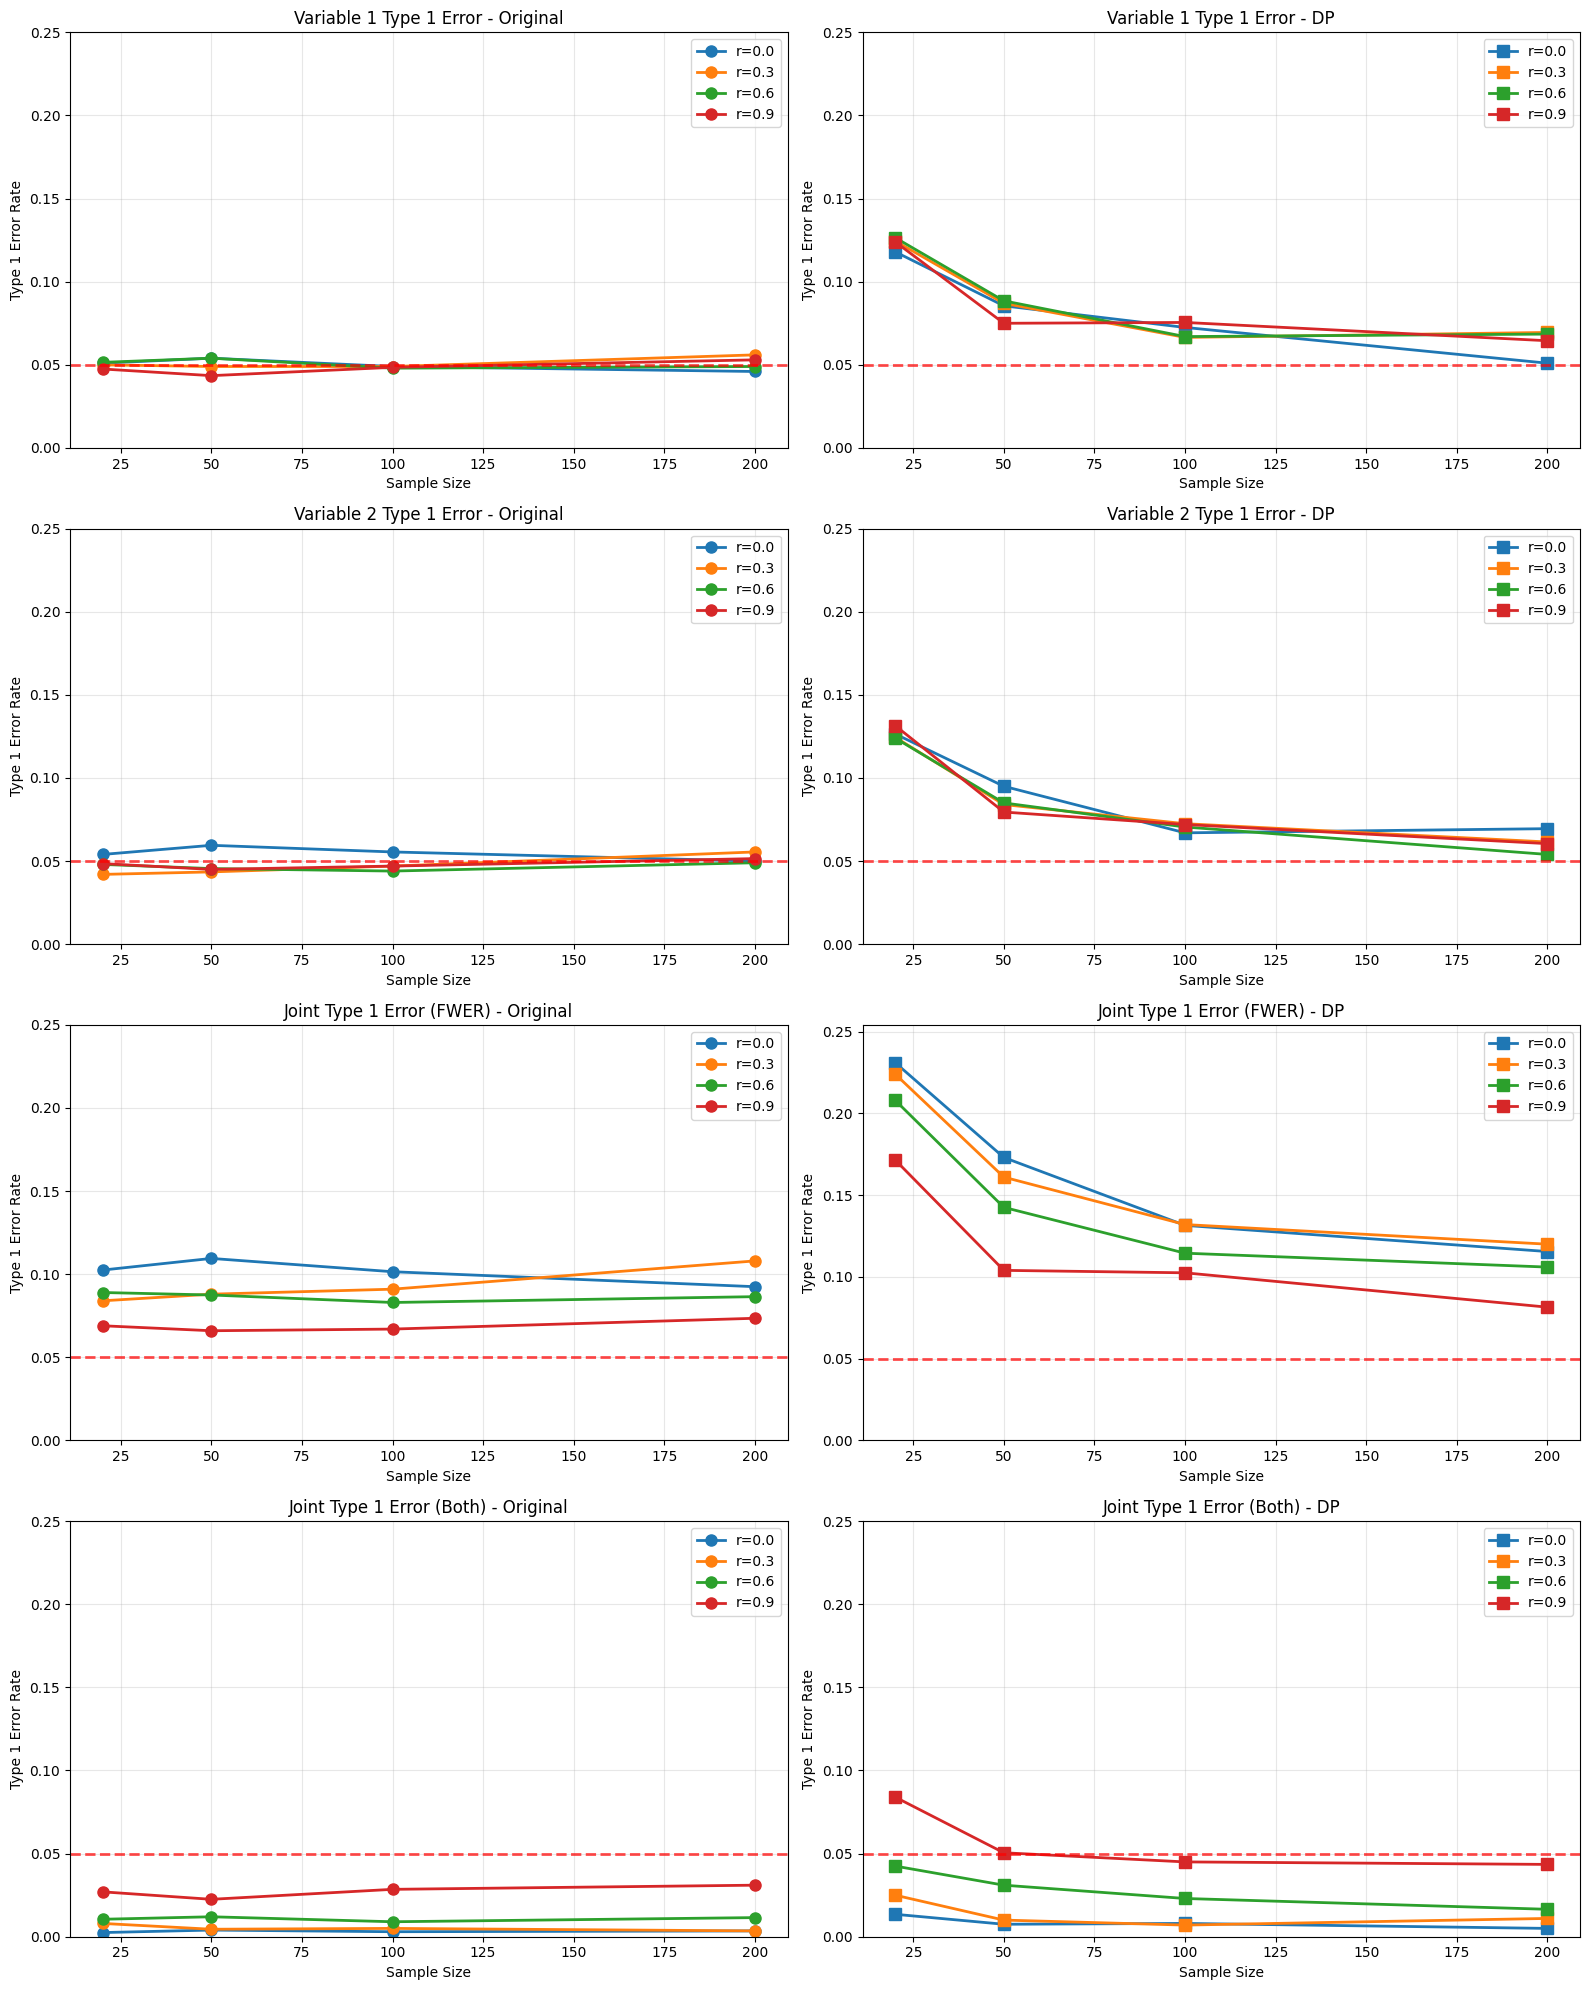

In [40]:
# Create 2D line plots for type 1 error
fig, axes = plt.subplots(4, 2, figsize=(16, 20))

metrics_to_plot = [
    ('orig_t1_error', 'dp_t1_error', 'Variable 1 Type 1 Error'),
    ('orig_t2_error', 'dp_t2_error', 'Variable 2 Type 1 Error'),
    ('orig_joint_error', 'dp_joint_error', 'Joint Type 1 Error (FWER)'),
    ('orig_both_error', 'dp_both_error', 'Joint Type 1 Error (Both)')
]

for i, (orig_metric, dp_metric, title) in enumerate(metrics_to_plot):
    # Original method
    ax_orig = axes[i, 0]
    for corr in correlations_bivariate:
        corr_data = type1_df[type1_df['correlation'] == corr]
        corr_data_sorted = corr_data.sort_values('sample_size')
        
        ax_orig.plot(corr_data_sorted['sample_size'], corr_data_sorted[orig_metric], 
                    'o-', linewidth=2, markersize=8, label=f'r={corr}')
    
    # Add reference line at α=0.05
    ax_orig.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax_orig.set_xlabel('Sample Size')
    ax_orig.set_ylabel('Type 1 Error Rate')
    ax_orig.set_title(f'{title} - Original')
    ax_orig.legend()
    ax_orig.grid(True, alpha=0.3)
    ax_orig.set_ylim(0, max(0.25, type1_df[orig_metric].max() * 1.1))
    
    # DP method
    ax_dp = axes[i, 1]
    for corr in correlations_bivariate:
        corr_data = type1_df[type1_df['correlation'] == corr]
        corr_data_sorted = corr_data.sort_values('sample_size')
        
        ax_dp.plot(corr_data_sorted['sample_size'], corr_data_sorted[dp_metric], 
                  's-', linewidth=2, markersize=8, label=f'r={corr}')
    
    # Add reference line at α=0.05
    ax_dp.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax_dp.set_xlabel('Sample Size')
    ax_dp.set_ylabel('Type 1 Error Rate')
    ax_dp.set_title(f'{title} - DP')
    ax_dp.legend()
    ax_dp.grid(True, alpha=0.3)
    ax_dp.set_ylim(0, max(0.25, type1_df[dp_metric].max() * 1.1))

plt.tight_layout()
plt.show()

## Power Analysis

Power analysis for different effect size combinations. We examine scenarios where at least one variable has a true effect.

In [41]:
# Power analysis - exclude null scenario
power_data = df[~((df['effect1'] == 0.0) & (df['effect2'] == 0.0))].copy()

# Calculate power by scenario
power_results = []

effect_scenarios = [
    (0.0, 0.5, "One Active (Var2)"),
    (0.5, 0.0, "One Active (Var1)"), 
    (0.2, 0.2, "Both Small"),
    (0.5, 0.5, "Both Medium"),
    (0.8, 0.8, "Both Large"),
    (0.2, 0.8, "Mixed Effects")
]

for effect1, effect2, scenario_name in effect_scenarios:
    for sample_size in sample_sizes_bivariate:
        for correlation in correlations_bivariate:
            subset = power_data[(power_data['effect1'] == effect1) & 
                               (power_data['effect2'] == effect2) &
                               (power_data['sample_size'] == sample_size) & 
                               (power_data['correlation'] == correlation)]
            
            if len(subset) == 0:
                continue
                
            # Original t-tests power
            orig_t1_power = subset['original_significant1'].mean()
            orig_t2_power = subset['original_significant2'].mean()
            orig_joint_power = (subset['original_significant1'] | subset['original_significant2']).mean()
            orig_both_power = (subset['original_significant1'] & subset['original_significant2']).mean()
            
            # DP t-tests power
            dp_t1_power = subset['dp_significant1'].mean()
            dp_t2_power = subset['dp_significant2'].mean()
            dp_joint_power = (subset['dp_significant1'] | subset['dp_significant2']).mean()
            dp_both_power = (subset['dp_significant1'] & subset['dp_significant2']).mean()
            
            power_results.append({
                'effect1': effect1,
                'effect2': effect2,
                'scenario': scenario_name,
                'sample_size': sample_size,
                'correlation': correlation,
                'n_sims': len(subset),
                'orig_t1_power': orig_t1_power,
                'orig_t2_power': orig_t2_power,
                'orig_joint_power': orig_joint_power,
                'orig_both_power': orig_both_power,
                'dp_t1_power': dp_t1_power,
                'dp_t2_power': dp_t2_power,
                'dp_joint_power': dp_joint_power,
                'dp_both_power': dp_both_power
            })

power_df = pd.DataFrame(power_results)

# Power summary by scenario
print("Power Analysis Summary")
print("="*70)
print(f"{'Scenario':<20} {'Variable':<12} {'Original':<12} {'DP':<12} {'Power Loss':<12}")
print("-"*70)

for scenario in power_df['scenario'].unique():
    scenario_data = power_df[power_df['scenario'] == scenario]
    
    for var, orig_col, dp_col in [('Variable 1', 'orig_t1_power', 'dp_t1_power'),
                                  ('Variable 2', 'orig_t2_power', 'dp_t2_power'),
                                  ('Joint (FWER)', 'orig_joint_power', 'dp_joint_power')]:
        orig_mean = scenario_data[orig_col].mean()
        dp_mean = scenario_data[dp_col].mean()
        power_loss = orig_mean - dp_mean
        
        print(f"{scenario:<20} {var:<12} {orig_mean:<12.4f} {dp_mean:<12.4f} {power_loss:<12.4f}")
    print()

Power Analysis Summary
Scenario             Variable     Original     DP           Power Loss  
----------------------------------------------------------------------
One Active (Var2)    Variable 1   0.0522       0.0888       -0.0367     
One Active (Var2)    Variable 2   0.8768       0.8614       0.0154      
One Active (Var2)    Joint (FWER) 0.8858       0.8814       0.0043      

One Active (Var1)    Variable 1   0.8741       0.8563       0.0178      
One Active (Var1)    Variable 2   0.0503       0.0876       -0.0373     
One Active (Var1)    Joint (FWER) 0.8818       0.8762       0.0056      

Both Small           Variable 1   0.4341       0.4601       -0.0260     
Both Small           Variable 2   0.4319       0.4596       -0.0277     
Both Small           Joint (FWER) 0.5571       0.5893       -0.0322     

Both Medium          Variable 1   0.8758       0.8560       0.0198      
Both Medium          Variable 2   0.8745       0.8579       0.0166      
Both Medium          Joint 

## Power Lines for Key Scenarios

Visualizing power across sample sizes and correlations for important effect size combinations.

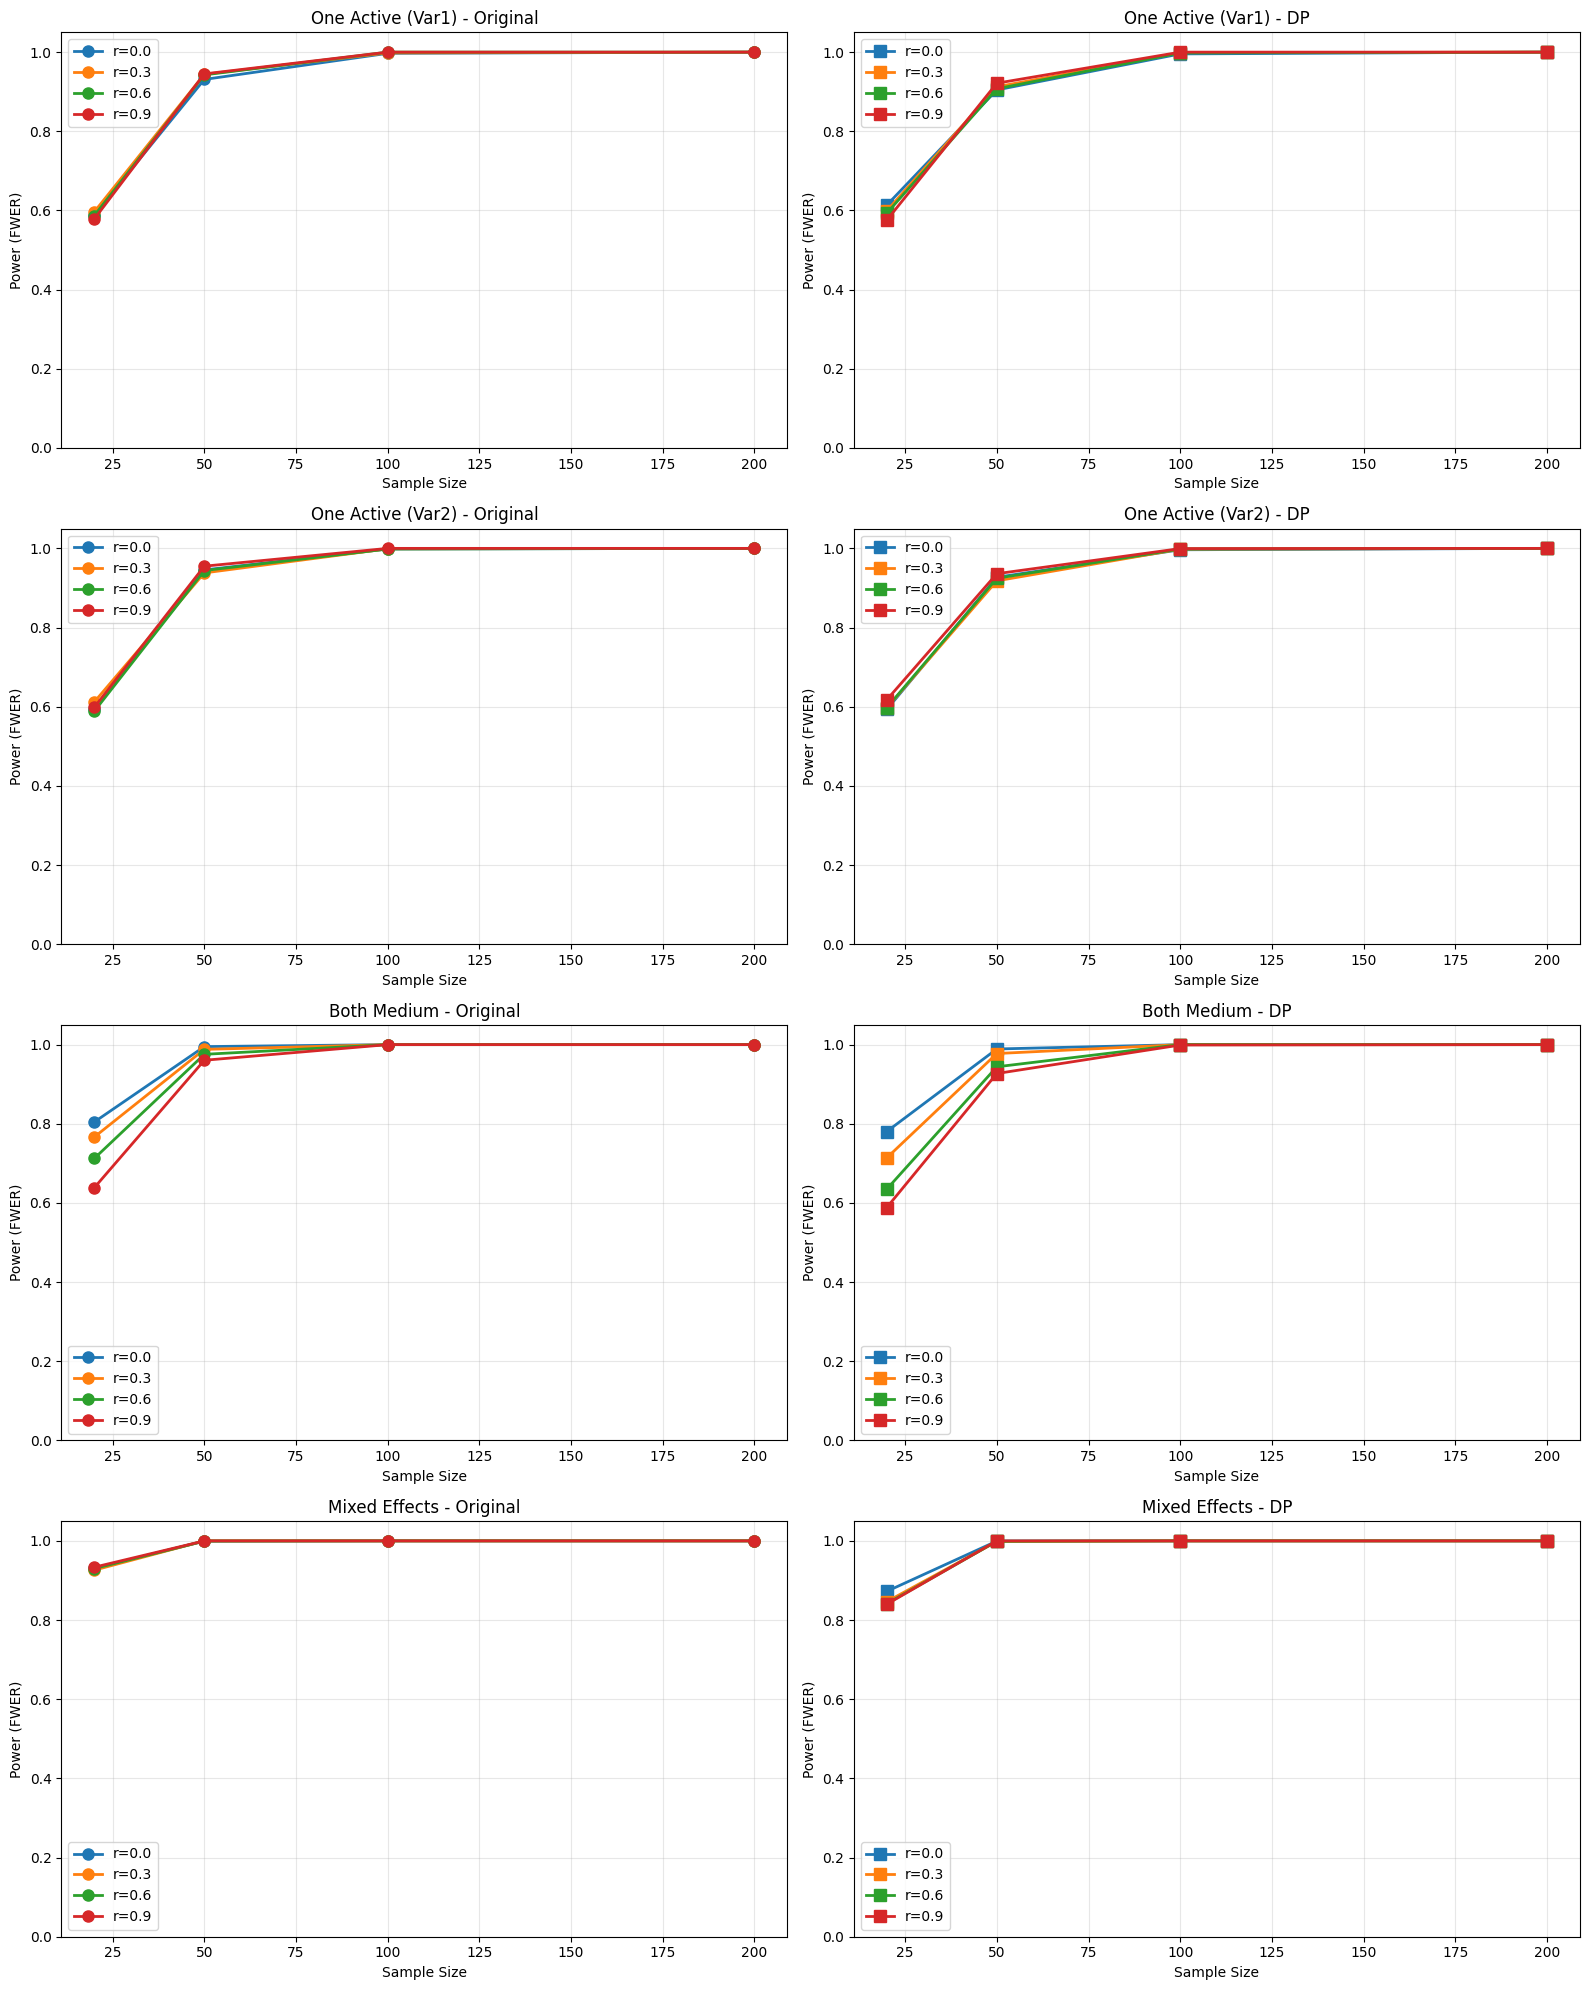

In [42]:
# Create 2D power plots for selected scenarios
scenarios_to_plot = [
    (0.5, 0.0, "One Active (Var1)"),
    (0.0, 0.5, "One Active (Var2)"), 
    (0.5, 0.5, "Both Medium"),
    (0.2, 0.8, "Mixed Effects")
]

fig, axes = plt.subplots(4, 2, figsize=(16, 20))

for plot_idx, (effect1, effect2, scenario_name) in enumerate(scenarios_to_plot):
    scenario_data = power_df[(power_df['effect1'] == effect1) & (power_df['effect2'] == effect2)]
    
    # Original method - Joint power (FWER)
    ax_orig = axes[plot_idx, 0]
    for corr in correlations_bivariate:
        corr_data = scenario_data[scenario_data['correlation'] == corr]
        corr_data_sorted = corr_data.sort_values('sample_size')
        
        ax_orig.plot(corr_data_sorted['sample_size'], corr_data_sorted['orig_joint_power'], 
                    'o-', linewidth=2, markersize=8, label=f'r={corr}')
    
    ax_orig.set_xlabel('Sample Size')
    ax_orig.set_ylabel('Power (FWER)')
    ax_orig.set_title(f'{scenario_name} - Original')
    ax_orig.legend()
    ax_orig.grid(True, alpha=0.3)
    ax_orig.set_ylim(0, 1.05)
    
    # DP method - Joint power (FWER)
    ax_dp = axes[plot_idx, 1]
    for corr in correlations_bivariate:
        corr_data = scenario_data[scenario_data['correlation'] == corr]
        corr_data_sorted = corr_data.sort_values('sample_size')
        
        ax_dp.plot(corr_data_sorted['sample_size'], corr_data_sorted['dp_joint_power'], 
                  's-', linewidth=2, markersize=8, label=f'r={corr}')
    
    ax_dp.set_xlabel('Sample Size')
    ax_dp.set_ylabel('Power (FWER)')
    ax_dp.set_title(f'{scenario_name} - DP')
    ax_dp.legend()
    ax_dp.grid(True, alpha=0.3)
    ax_dp.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

## Power Differences: Original vs DP with Confidence Intervals

Analysis of power loss due to differential privacy with binomial confidence intervals for each scenario.

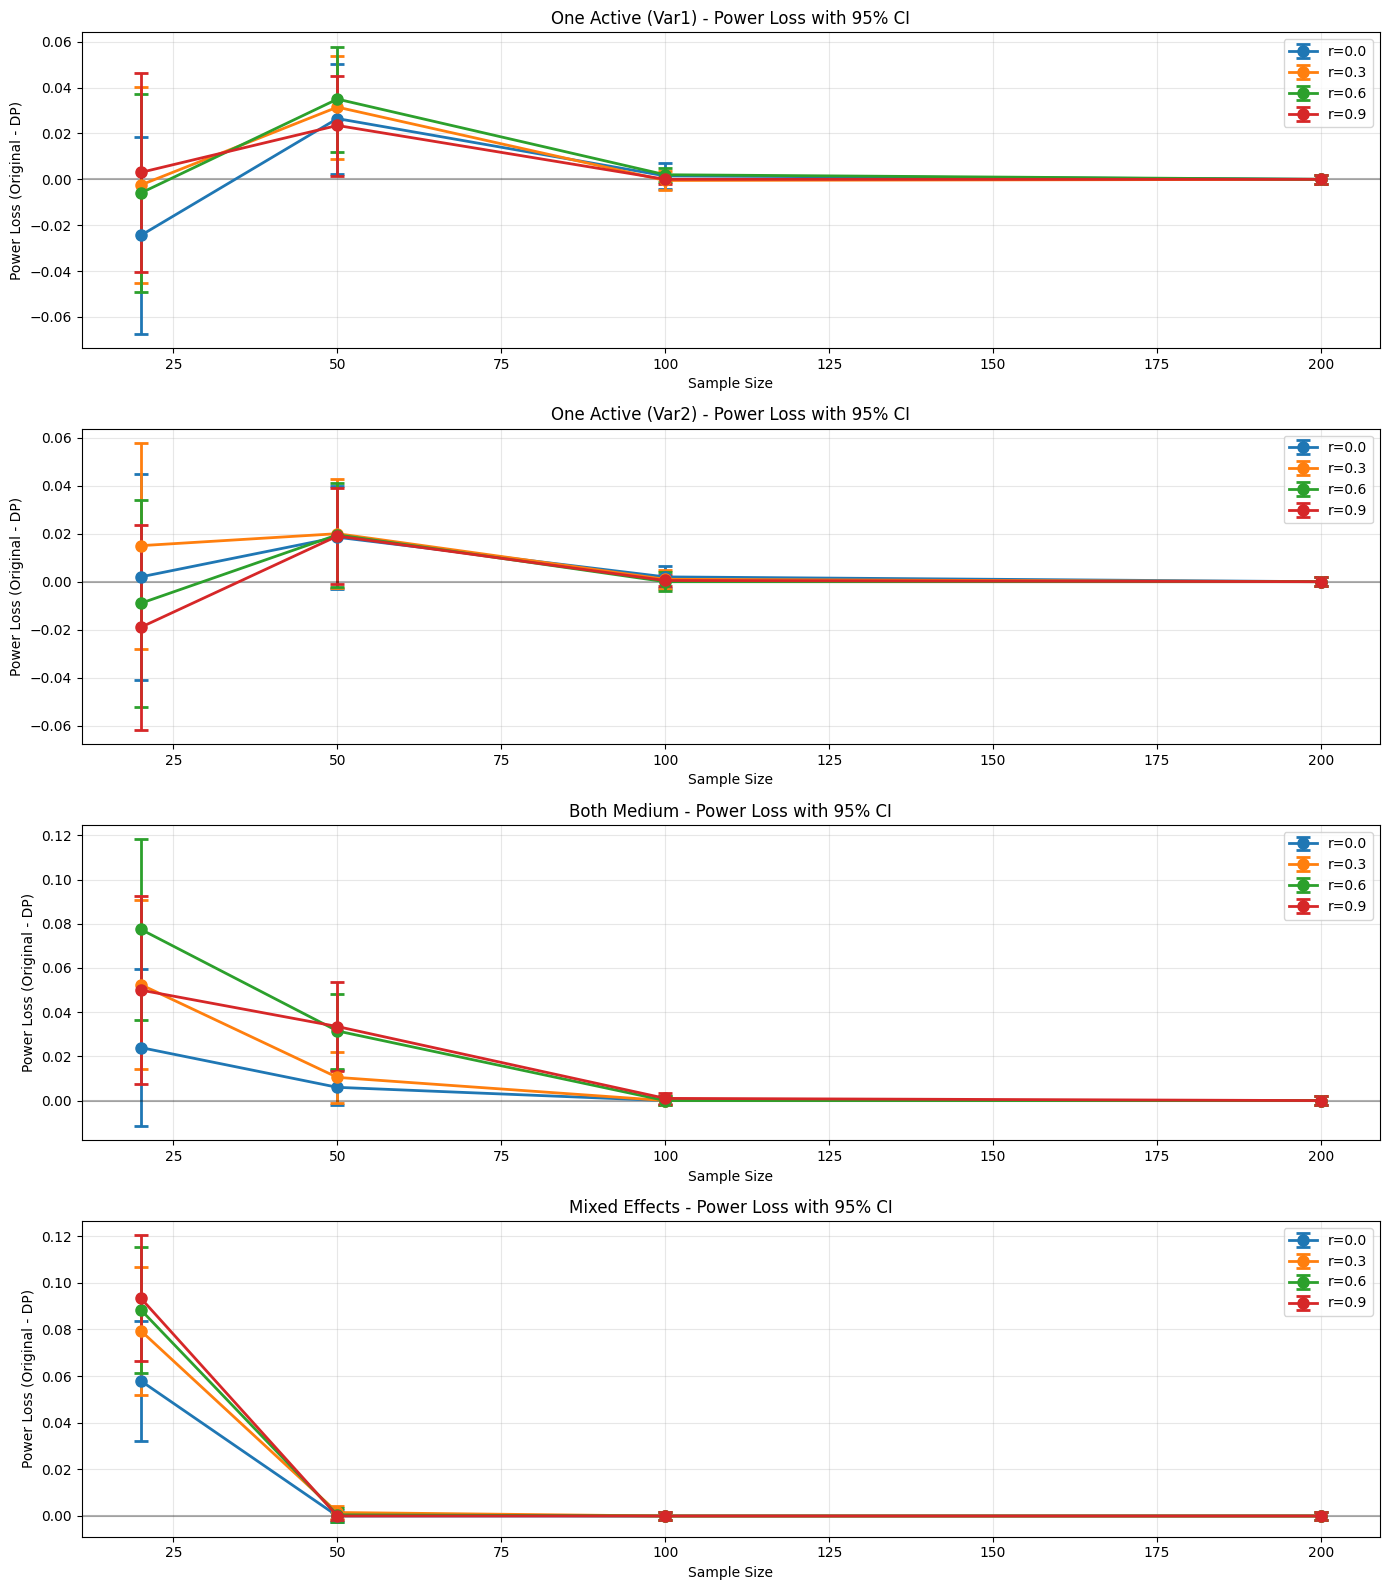

Power Loss Summary (Original - DP Joint Power)
Scenario             Sample Size  r=0.0    r=0.3    r=0.6    r=0.9   
--------------------------------------------------------------------------------
One Active (Var1)    20           -0.025   -0.002   -0.006   0.003   
One Active (Var1)    50           0.027    0.031    0.035    0.023   
One Active (Var1)    100          0.001    -0.001   0.002    0.000   
One Active (Var1)    200          0.000    0.000    0.000    0.000   

One Active (Var2)    20           0.002    0.015    -0.009   -0.019  
One Active (Var2)    50           0.018    0.020    0.019    0.019   
One Active (Var2)    100          0.002    0.001    0.000    0.000   
One Active (Var2)    200          0.000    0.000    0.000    0.000   

Both Medium          20           0.024    0.052    0.078    0.050   
Both Medium          50           0.006    0.010    0.032    0.033   
Both Medium          100          0.000    0.000    0.000    0.001   
Both Medium          200      

In [45]:
# Calculate power differences with binomial confidence intervals
from scipy.stats import binom
import numpy as np

def binomial_ci(successes, trials, confidence=0.95):
    """Calculate binomial confidence interval using normal approximation"""
    if trials == 0:
        return 0, 0
    
    p = successes / trials
    alpha = 1 - confidence
    z = 1.96  # 95% CI
    
    # Wilson score interval (better for small samples)
    denominator = 1 + z**2 / trials
    centre = (p + z**2 / (2 * trials)) / denominator
    half_width = z * np.sqrt((p * (1 - p) + z**2 / (4 * trials)) / trials) / denominator
    
    return max(0, centre - half_width), min(1, centre + half_width)

# Create power difference plot
scenarios_to_plot = [
    (0.5, 0.0, "One Active (Var1)"),
    (0.0, 0.5, "One Active (Var2)"), 
    (0.5, 0.5, "Both Medium"),
    (0.2, 0.8, "Mixed Effects")
]

fig, axes = plt.subplots(4, 1, figsize=(14, 16))

for plot_idx, (effect1, effect2, scenario_name) in enumerate(scenarios_to_plot):
    ax = axes[plot_idx]
    scenario_data = power_df[(power_df['effect1'] == effect1) & (power_df['effect2'] == effect2)]
    
    # Calculate power differences for each correlation
    for corr in correlations_bivariate:
        corr_data = scenario_data[scenario_data['correlation'] == corr]
        corr_data_sorted = corr_data.sort_values('sample_size')
        
        sample_sizes_plot = []
        power_diffs = []
        ci_lower = []
        ci_upper = []
        
        for _, row in corr_data_sorted.iterrows():
            sample_size = row['sample_size']
            n_sims = row['n_sims']
            
            # Calculate power difference (original - DP)
            orig_power = row['orig_joint_power']
            dp_power = row['dp_joint_power']
            power_diff = orig_power - dp_power
            
            # Calculate confidence intervals for the difference
            # Using the fact that both are binomial proportions from the same trials
            orig_successes = int(orig_power * n_sims)
            dp_successes = int(dp_power * n_sims)
            
            # CI for difference of proportions (approximate)
            orig_ci_lower, orig_ci_upper = binomial_ci(orig_successes, n_sims)
            dp_ci_lower, dp_ci_upper = binomial_ci(dp_successes, n_sims)
            
            # Difference CI (can be negative - that's fine!)
            diff_ci_lower = (orig_ci_lower - dp_ci_upper)
            diff_ci_upper = (orig_ci_upper - dp_ci_lower)
            
            sample_sizes_plot.append(sample_size)
            power_diffs.append(power_diff)
            ci_lower.append(diff_ci_lower)
            ci_upper.append(diff_ci_upper)
        
        # Calculate error bar lengths (can handle negative CIs)
        error_lower = np.array(power_diffs) - np.array(ci_lower)
        error_upper = np.array(ci_upper) - np.array(power_diffs)
        
        # Plot power differences with error bars
        ax.errorbar(sample_sizes_plot, power_diffs, 
                   yerr=[error_lower, error_upper],
                   fmt='o-', linewidth=2, markersize=8, capsize=5, capthick=2,
                   label=f'r={corr}')
    
    # Add zero reference line
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('Power Loss (Original - DP)')
    ax.set_title(f'{scenario_name} - Power Loss with 95% CI')
    ax.legend()
    ax.grid(True, alpha=0.3)
    # Remove artificial y-limit restrictions to allow full CI range
    ax.set_ylim(None, None)

plt.tight_layout()
plt.show()

# Summary table of power losses
print("Power Loss Summary (Original - DP Joint Power)")
print("="*80)
print(f"{'Scenario':<20} {'Sample Size':<12} {'r=0.0':<8} {'r=0.3':<8} {'r=0.6':<8} {'r=0.9':<8}")
print("-"*80)

for effect1, effect2, scenario_name in scenarios_to_plot:
    scenario_data = power_df[(power_df['effect1'] == effect1) & (power_df['effect2'] == effect2)]
    
    for sample_size in sample_sizes_bivariate:
        size_data = scenario_data[scenario_data['sample_size'] == sample_size]
        
        row_values = [scenario_name, sample_size]
        for corr in correlations_bivariate:
            corr_data = size_data[size_data['correlation'] == corr]
            if len(corr_data) > 0:
                power_loss = corr_data['orig_joint_power'].iloc[0] - corr_data['dp_joint_power'].iloc[0]
                row_values.append(f"{power_loss:.3f}")
            else:
                row_values.append("N/A")
        
        print(f"{row_values[0]:<20} {row_values[1]:<12} {row_values[2]:<8} {row_values[3]:<8} {row_values[4]:<8} {row_values[5]:<8}")
    print()

# Conclusions

For the bivariate t-test, global differential privacy with covariance-aware noise maintains type 1 error control like the univariate case, with similar expected Familly Wise type 1 error rates. Power is reduced compared to the original test, especially at small sample sizes and high correlations, but improves with larger samples. The approach effectively balances privacy and statistical validity in multivariate settings.